## The task description

The task is to develop an algorithm to disambiguate people contributing to various scientific events (e.g. talks, presentations, sessions). For this, you have to create one profile per person. This profile will have all the contribution from that person (100% recall) and no other contributions from anyone else (100% precision). Please avoid unnecessary duplicates as well as mixing contributions from different scientists despite similar names/focus-areas.

### Datasets
Use the following datasets to solve the problem:

- data.json: List of 5086 various contributions, described by several attributes (features), e.g. names, information about the workplace of the author, its geolocation, and focus areas (key topics covered in contribution)
- ground_truth.json: "Ground truth" - actual groups of contributions from the data file (each contribution is assigned to a person)
- persons.json: The list of unique people.

### Expected outcomes 
The solution should be an algorithm or model which allows us to disambiguate people based on the data.json, by complete the following points:

• Analyze the data 

• Build a model and provide a (minimal) solution 

• Measure the performance of the model (F1, precision, recall, etc)  

• Describe the pros and cons of the solution and how you can improve it if you had more time 

• Explain how your solution scales when applied to millions of data. You donn't have to develop a scalable solution, but you may come up with a proposal.

## Problem statement and initial assumpations
Initally I thought of using spacy or BERT language models (even I did try it for fun, but I've commented them out for now). However, as the features are lacking the surrounding context, using more sophsticated (e.g., NLP trasnfer learning via Word2Vec/GloVe/FastTExt or BERT-based) wouldn't improve performance. 

I also originally thought the Spacy approach is going to be useful to do some word sense disambiguation as I thought there would be free texts (e.g., abstract column of the speaker) with the speaker entity that can be plucked or we could just use for full name to see who is who. Eventually, I didn't go for this approach this as this wouldn't create a model approach we could use just a closest match procedure to name. 

Therefore, encoding the features myself using TF-IDF or counter vectorized (NLP feature extractor from sklearn library) for moderate performance. In my understanding, this is less a word sense disambigation task, just entity linking (cf. https://link.springer.com/article/10.1007/s11192-021-03951-w). 

## Step-1: data preparation and feature engineering
The data prepartion for predictive modelling has several steps, including data parsing, pre-processing,
 followed by feature creation. 
 
### Reading and parsing available data

In [64]:
#!/usr/bin/env python
# coding: utf-8

# Loading required libraries and python modeules
# Pandas and numpy for data processing and liner algebra
import numpy as np  
import pandas as pd  

# For plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar for python and CLI
from tqdm import tqdm

## Importing sklearn modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## Suprass some hectic warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Use Keras with TensorFlow backend 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout

from utils import *

In [2]:
# 1. data.json: List of 5086 various contributions, described by several attributes (features), e.g. names, information about the workplace of the author, its geolocation, and focus areas (key topics covered in contribution)
df = pd.read_json("data.json")

# 2. ground_truth.json: "Ground truth" - actual group s of contributions from the data file, where each contribution is assigned to a person
df_ground_truth = pd.read_json("ground-truth.json")

# 3. persons.json: The list of unique people in the dataset
df_person = pd.read_json("persons.json")  # do i need this to map back?

In [3]:
### Labelling the dataframe with ground_truth for easier work
df = df.join(df_ground_truth.set_index('contributionId'), on='contribution_id')

In [4]:
df['str_focus_areas'] = [','.join(map(str, l)) for l in df['focus_areas']]
df['str_gpes'] = [','.join(map(str, l)) for l in df['focus_areas']]
df['str_orgs'] = [' '.join(map(str, l)) for l in df['focus_areas']]

# We create full name for each contributor to be used as a feature (well, maybe not a good idea, but let's do it anyway)
df['cm_full_name'] = df[["first_name","middle_name","last_name"]].agg(' '.join, axis=1)
df["features"] = df[["cm_full_name","workplace","str_focus_areas","str_gpes","str_orgs"]].agg(' '.join, axis=1)

<AxesSubplot:xlabel='personId'>

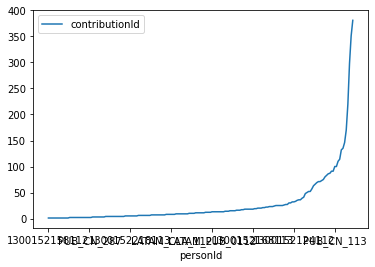

In [5]:
# contribution distribution
df_ground_truth.groupby("personId").count().sort_values(by=['contributionId']).plot()

The contributions are not uniformly distributed, rather skewed. Further, as we don't have free text, the entity linkers are going to fail , as far as I understood. This means, it could benefit from a knowledge graph problem, e.g., treating the problem as a wiki disambiguation problem. 

In [6]:
# Unique persons
n_persons = len(df_person)
len(n_persons.unique())

193

In [7]:
author_mapping_dict = {label:idx for idx, label in enumerate(df["personId"])}
id_author_mapping_dict = dict((v, k) for k, v in author_mapping_dict.items())

d_labels = df["personId"].map(author_mapping_dict)

In [8]:
# Let's see how many unique labels we got
len(np.unique(d_labels))

187

### Feature engineering and feature vector creation

Initially tried with TFIDF (e.g., tfidf vectorizer from sklearn), but did not really help as the features miss the context and semantics. 

```
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf_vec = tfidf.fit_transform(df["features"].values.tolist())
train_tfidf = tfidf_vec.transform(X_train.values.tolist())
test_tfidf = tfidf_vec.transform(X_test.values.tolist())
```

In [9]:
# Let's see what's we got to be used as features for our model 
df["features"].head()

0    H. L. A. Janssen netherlands Hepatology Genera...
1    H  Janssen canada Topic: Gastroenterology,Ther...
2    H. L. A. Janssen netherlands Topic: Infections...
3    Eric P. Winer  Topic: Solid Tumors,Cancer Radi...
4    Eric P. Winer  Metastases General,Metastases /...
Name: features, dtype: object

In [10]:
# Using CountVectorizer, we do lose any order with those feature columns with below method however has no effect anyway
cv = CountVectorizer()
cv_vec = cv.fit_transform(df["features"].values.tolist())

### Train and test set creation
We use 80% for training an estimator, the rest 20% for evaluation the trained model. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(cv_vec, d_labels, test_size=0.2, random_state=42)

In [62]:
X_train.shape

(4070, 2625)

In [63]:
y_train.shape

(4070,)

In [59]:
# This won't give better performance as the features have no textual semantics in them and are just text labels. 
# model = SentenceTransformer('distilbert-base-uncased')
# train_embeddings = model.encode(X_train.values.tolist())
# test_embeddings = model.encode(X_test.values.tolist())

In [60]:
# Eval fit - how much overfitting? not really standardise labels. O
# mse_train = mean_squared_error(y_train, model.predict(train_vec))
# mse_test = mean_squared_error(y_test, y_pred)
# print("RF with full trees, Train MSE: {} Test MSE: {}".format(mse_train, mse_test))

## Step-2: model creation and training
I could use Naive Bayes or SVM, followed by more powerful models like DT, RF or GBT or even DNN (e.g., LSTM, CNN, Bi-LSTM, Conv-LSTM) or transformer models (e.g., BERTs).

### Creating model and preparing for k-fold cross-validation with random search 
As the solution asks to create an inital or baseline model, let's create a random forest model. RF model usually outperforms clssisic ML models, but it may not be the case for us. Further, in order to avoid overfitting the training data, I use random search of parameters using 3-fold cross validation.   

In [12]:
## Create a RF estomator 
rf = RandomForestClassifier()

## Now let's define some params before creating a random param grid. 
n_estimators = [16, 32, 64, 128]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

### Training the model
I know it's exhaistive as the it will search across 100 different combinations, using all available CPU cores things can be made faster.

In [13]:
model = rf_model.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/rkarim/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.8s finished


## Step-3: evaluating the trained RF model on test set 
Now that the RF model is trained, we evaluate the performence on the 20% held-out test set. This is, hopefully, give some good basis or justification why RF was a good and reasonable choice. To upport the arument, I'll further use some sort of AutoML library such as PyCaret. 

In [14]:
y_pred = model.predict(X_test)
# print("Random search + RF")

## Calculating metrics for each label and their unweighted mean. This does not take label imbalance into account.
# acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, y_pred)

# print("Accuracy: " + str(acc))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1: " + str(f1))
print("MCC: " + str(mcc))

## How about using weighted average? Well, then it would calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

Precision: 0.7321613041371107
Recall: 0.7176087064240049
F1: 0.7117062001870851
MCC: 0.8524394290706632


/home/rkarim/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rkarim/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Step-4: Using AutoML for meta- and ensemble learning 
The idea is employing meta- and ensemble learning using well-known (and one of my favourites) PyCaret library. My ide is to use blending and stacking top-k models to observe if we can get some performance boost. 

- i) Blending models: a method of ensembling which uses consensus among estimators to generate final predictions. The idea behind blending is to combine different ML models and use a majority vote or the average predicted probabilities in case of classification to predict the final outcome. 
- ii) Stacking models: a method of ensembling that uses meta learning approach. The idea behind stacking is to build a meta model that generates the final prediction using the prediction of multiple base estimators. 

In [23]:
## Using PyCaret
# Pycaret expect the training data in Pandas DataFrame, where features and labels can be identifiable using column names. 
# So, let's first conver the vector into dataframe format. 
features_DF = pd.DataFrame(cv_vec.toarray())
#labels_DF = pd.DataFrame(d_labels.toarray())

In [26]:
# Now let's conver the label Series into a DataFrame too 
d_labels_DF = d_labels.to_frame()

In [48]:
# Finally, create a new column in the feature dataframe. 
features_DF['personId'] = d_labels_DF

In [51]:
# Initialize Setup
from pycaret.classification import *
clf1 = setup(features_DF, target = 'personId', session_id=123, log_experiment=True, experiment_name='disambiguate1')

,Description,Value
0,session_id,123
1,Target,personId
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(5088, 2626)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,2622
8,Ordinal Features,False
9,High Cardinality Features,False


In [52]:
## Compare Baseline
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8658,0.0000,0.8038,0.8499,0.8477,0.8620,0.8634,0.1290
gbc,Gradient Boosting Classifier,0.8298,0.0000,0.7534,0.8350,0.8217,0.8252,0.8263,75.1690
dt,Decision Tree Classifier,0.8197,0.0000,0.7005,0.8168,0.8071,0.8150,0.8163,0.1670
et,Extra Trees Classifier,0.8017,0.0000,0.6548,0.7815,0.7804,0.7964,0.7975,0.7320
lr,Logistic Regression,0.8012,0.0000,0.6378,0.7686,0.7730,0.7954,0.7973,38.4140
rf,Random Forest Classifier,0.7964,0.0000,0.6417,0.7622,0.7680,0.7907,0.7921,0.4550
nb,Naive Bayes,0.7150,0.0000,0.5821,0.7245,0.7071,0.7082,0.7095,0.6430
lightgbm,Light Gradient Boosting Machine,0.7122,0.0000,0.4730,0.6829,0.6833,0.7036,0.7064,11.9820
lda,Linear Discriminant Analysis,0.6248,0.0000,0.4743,0.7748,0.6699,0.6181,0.6239,4.5270
svm,SVM - Linear Kernel,0.5737,0.0000,0.3907,0.6694,0.5733,0.5635,0.5806,9.3870


In [53]:
## Based on intitial result, create top-k models, that is ridge, gbc, and dt classifiers 
ridge = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8683,0.0000,0.8166,0.8562,0.8510,0.8648,0.8658
1,0.8736,0.0000,0.7807,0.8350,0.8482,0.8701,0.8709
2,0.8427,0.0000,0.7551,0.8336,0.8276,0.8381,0.8397
3,0.8427,0.0000,0.8156,0.8237,0.8253,0.8382,0.8395
4,0.8736,0.0000,0.8769,0.8796,0.8610,0.8699,0.8728
5,0.8904,0.0000,0.8048,0.8718,0.8753,0.8875,0.8884
6,0.8764,0.0000,0.8194,0.8658,0.8560,0.8729,0.8751
7,0.8596,0.0000,0.7852,0.8513,0.8426,0.8555,0.8573
8,0.8792,0.0000,0.8248,0.8572,0.8606,0.8760,0.8766
9,0.8511,0.0000,0.7590,0.8247,0.8293,0.8470,0.8479


In [56]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8431,0.0000,0.7842,0.8352,0.8292,0.8390,0.8399
1,0.8539,0.0000,0.7929,0.8425,0.8406,0.8500,0.8507
2,0.8034,0.0000,0.7189,0.8051,0.7934,0.7979,0.7993
3,0.7978,0.0000,0.7577,0.8221,0.7977,0.7922,0.7930
4,0.8455,0.0000,0.8222,0.8718,0.8466,0.8414,0.8430
5,0.8455,0.0000,0.7344,0.8629,0.8450,0.8415,0.8424
6,0.8090,0.0000,0.7240,0.8207,0.8032,0.8040,0.8053
7,0.8399,0.0000,0.7412,0.8379,0.8251,0.8353,0.8371
8,0.8315,0.0000,0.7197,0.8256,0.8191,0.8268,0.8277
9,0.8287,0.0000,0.7387,0.8265,0.8174,0.8241,0.8249


In [55]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8347,0.0000,0.7100,0.8157,0.8180,0.8306,0.8312
1,0.8118,0.0000,0.6660,0.8037,0.8009,0.8070,0.8075
2,0.7809,0.0000,0.6633,0.7830,0.7672,0.7748,0.7770
3,0.8006,0.0000,0.6976,0.8054,0.7919,0.7955,0.7963
4,0.8287,0.0000,0.7660,0.8512,0.8258,0.8241,0.8259
5,0.8652,0.0000,0.7340,0.8718,0.8618,0.8618,0.8627
6,0.8146,0.0000,0.6843,0.7992,0.7924,0.8093,0.8117
7,0.8174,0.0000,0.6734,0.8130,0.8021,0.8124,0.8141
8,0.8287,0.0000,0.7240,0.8116,0.8090,0.8240,0.8258
9,0.8146,0.0000,0.6866,0.8130,0.8013,0.8098,0.8107


In [57]:
tuned_ridge = tune_model(ridge)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8655,0.0000,0.8048,0.8474,0.8450,0.8619,0.8630
1,0.8792,0.0000,0.7890,0.8401,0.8535,0.8759,0.8767
2,0.8427,0.0000,0.7541,0.8358,0.8279,0.8381,0.8398
3,0.8399,0.0000,0.8114,0.8264,0.8222,0.8353,0.8365
4,0.8764,0.0000,0.8773,0.8834,0.8641,0.8728,0.8757
5,0.8904,0.0000,0.8116,0.8699,0.8743,0.8875,0.8884
6,0.8736,0.0000,0.8191,0.8606,0.8536,0.8700,0.8718
7,0.8596,0.0000,0.7748,0.8515,0.8435,0.8556,0.8573
8,0.8736,0.0000,0.7996,0.8446,0.8535,0.8703,0.8708
9,0.8596,0.0000,0.7684,0.8310,0.8385,0.8557,0.8565


In [ ]:
tuned_gbc = tune_model(gbc)

In [59]:
tuned_dt = tune_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.3333,0.0000,0.1134,0.2963,0.2804,0.3002,0.3183
1,0.3146,0.0000,0.1154,0.3290,0.2748,0.2838,0.3130
2,0.3258,0.0000,0.1176,0.3042,0.2761,0.2954,0.3090
3,0.3287,0.0000,0.1297,0.3185,0.2860,0.2995,0.3124
4,0.3287,0.0000,0.1167,0.3161,0.2846,0.2974,0.3137
5,0.3399,0.0000,0.1272,0.2941,0.2781,0.3098,0.3247
6,0.3287,0.0000,0.1101,0.2839,0.2768,0.2972,0.3122
7,0.3090,0.0000,0.1068,0.2814,0.2669,0.2787,0.2909
8,0.3146,0.0000,0.1043,0.3156,0.2736,0.2840,0.3163
9,0.2753,0.0000,0.0944,0.2767,0.2370,0.2414,0.2544


In [ ]:
blender = blend_models(estimator_list = [tuned_lr, tuned_dt], method = 'soft')

In [ ]:
stacker = stack_models(estimator_list = [tuned_ridge, tuned_dt], meta_model=ridge)

## Step-5: Naive validation on riginal data for output reasons + sharing

In [ ]:
author_mapping_dict = { label:idx for idx,label in enumerate(df["personId"])}
id_author_mapping_dict = dict((v, k) for k, v in author_mapping_dict.items())

d_labels = df["personId"].map(author_mapping_dict)

d_vec = cv.transform(df["features"].values.tolist())
np.argmax(model.predict_proba(d_vec), axis=1)

# res_prob = model.predict_proba(d_vec)
y_res = [id_author_mapping_dict[i] for i in d_labels]
# different metrics but might be able to get a conf out of a randomforrest
# y_conf = [res_prob[idx][m_i] for idx, m_i in enumerate([np.argmax(model.predict_proba(d_vec),axis=1)])][0]
df["pred"] = y_res
df.to_csv("full_output_matches.tsv", sep ='\t', index=False)
df[["index", "contribution_id", "features", "personId", "pred"]].to_csv("output_matches.tsv", sep ='\t', index=False)
# df[["index", "contribution_id", "features", "personId", "pred"]][:25].to_csv("sample_matches.tsv", sep ='\t', index=False)

In [ ]:
## Let's randomly checks some rows to see how the model predicted
sm_df = pd.read_csv("output_matches.tsv", sep ='\t')
sm_df.tail()

## Step-6: Analysis of the solution - pros and cons
Although getting an f1-score of 71% is not good, unfortunately. On a positive note: getting an MCC score of above 85% suggests that the predictions were strongly correlated with the ground truth, yielding a Pearson product-moment correlation coefficient.
Further, this solution has not take into consideration all the features. Besides, names are merged with other features, which shouldn't be the ideal case. We could see if having a name column (i.e., full-name) can give some hints of unique contributions.   

### Improvement suggestions 
I'd like to answer to this from several perspectives like data preprocessing, employing meta- and ensemble learning approaches, improving interpretability, and having other features, etc: 

- First, based on available data we have, using more sophsticarted preprocessing: we could employ better preprocessing steps to clean the features column. Because only removing some stop words doesn't make the texts clean and meaningful, but also non-English texts that are there in the dataset need to be removed. To the end, having the model trained on comprihensively preprocessed text would certainly boost the performance. 
- Second, employing meta- and ensemble learning: human involvement in the provision and curation of data can make a model's predictions not only susceptible to bias but also erroneous outcomes. Thus, a majority voting-based ensemble from a panel of independent experts can provide a fairer and trustworthy prediction than a single expert, using meta learning approach and come up with ensemble model would certainly improve the permance, as we already saw from the performance analysis (step-4). I'd go for two approaches for this namely: i) blending models - a method of ensembling which uses consensus among estimators to generate final predictions. The idea behind blending is to combine different ML models and use a majority vote or the average predicted probabilities in case of classification to predict the final outcome, ii) stacking models -a method of ensembling that uses meta learning approach. The idea behind stacking is to build a meta model that generates the final prediction using the prediction of multiple base estimators. 
- Third, the approach we have seen so far is pretty-black box approach. So, using some sort of interpretable ML approach (e.g., SHAP, LIME, sensitibity analysis, LRP), we can identify which factors tend the model make a certain prediction, by exposing important terms from the 'feature' column. 
- Fourth, having an abstract column of the speaker would have been useful containing surround contexts, though. Some sort of larger approach with knowledge base, e.g., entity inking (recognizing and disambiguating named entities) to a knowledge base could be helpful, but I'm not sure. To relate this with a more practical entity linking: the current setting is more setting each entity as a unique person. This person entity might be less effective, and the benefits of entity linking might be less that a clustering/classifiering. There are some wiki entity approaches with knowledge base though that link x person with same names to their unique fieldshowever the data doesn't really match with doing that. You need more free text data with the use of names to benefit with these problems, and it isn't really needed as you already have feature columns. 

### On a view to scaling the solution up to millions of records! 
Although providing insights on scaling up my naive solution would depends on how many distinct speakers are in this dataset. Still, scaling the solution for upto millions of records won't be a huge challenges as long as we use some scalable hardware and software infrastructure. For example, processing the records on a commodity hardware or cloud using Spark (or DASK) followed by modelling using Spark ML would give a good basis. By the way, for this, the model might need to retrained on new claaseswhere these match unique speakers. 

This approach I used was just with the dataset provided. Most the preprocessing and methods are reusable but a different hierarchical clustering might be more effective depending on spread of the larger dataset. In such a setting, even utilizing CPUs having parallel cores could be employed. Nevertheless, the training can be distributed across nodes or GPUs (e.g., imagine we're simply training a CNN or Bi-LSTM or transformer model) rather than on CPU cores. To simplify this, I'd: 

- i) first do the initial data processing and feature enginerring on Spark, 
- ii) get the vectros or embeddings using more sophsticated word/sentence embeddings or tarsnformers to be cached locally, 
- iii) training the classifier accross GPUs (or CPUs using Spark or DASK). 

### On recommendation of  using word/sentence embeddings/transformer models  
I'm treating this more as a key encoded feature as the benefits of using a word embedding isn't shown as they have no language context. As mentioned, having an abstract of the talk that might be time to use the word embeddings, and we can use that an as a feature. OTOH, as transformer-based approach already outperform DNN + word/sentence embeddings-based approach in almost all NLP tasks, I'd suggest to go for BERTs in it's differnt domain-specifc variants. However, there are several considerations too: 

- If you really need a faster inference speed but ready to sacrifice some % on prediction metrics, DistilBERT is a reasonable choice for getting the embeddings from. 
- However, if you are looking for the best prediction metrics, you'd be better off with Facebook's RoBERTa. 
- Theoratically, XLNet's permutation based training should handle dependencies well, and might work better in longer-run. 
- Finnaly, using some domain-specific BERT variants such as Bio/SciBERT could be an options too  

<!-- ## Step-6: Trying with DNN baselines, e.g., MLP in Keras -->

In [34]:
# # import numpy as np
# X_train_mlp = X_train.toarray()
# X_test_mlp = X_test.toarray()

In [35]:
# ## Kearns need the labels in categorical 
# def toOneHotLabels(label):
#     label_encoder = LabelEncoder()
#     integer_encoded = label_encoder.fit_transform(label)

#     # binary encode
#     onehot_encoder = OneHotEncoder(sparse=False)
#     integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#     onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded)
    
#     return onehot_encoded_train

# onehot_encoded_train = toOneHotLabels(y_train)
# onehot_encoded_test = toOneHotLabels(y_test)

In [57]:
# from keras import backend as K

# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [58]:
# # first neural network with keras tutorial
# # define the keras model
# model = Sequential()
# model.add(Dense(2048, input_dim=2625, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(182, activation='softmax'))

# # compile the keras model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', recall_m, precision_m, f1_m])

# # fit the keras model on the dataset
# model.fit(X_train_mlp, onehot_encoded_train, epochs=20, batch_size=128)

Epoch 1/20
3408/3408 [==============================] - 1s 427us/step - loss: 3.9011 - acc: 0.3377 - recall_m: 0.1074 - precision_m: 0.6278 - f1_m: 0.1803
Epoch 2/20
3408/3408 [==============================] - 1s 290us/step - loss: 2.1376 - acc: 0.5754 - recall_m: 0.3480 - precision_m: 0.8571 - f1_m: 0.4912
Epoch 3/20
3408/3408 [==============================] - 1s 289us/step - loss: 1.2109 - acc: 0.7400 - recall_m: 0.5883 - precision_m: 0.9303 - f1_m: 0.7193
Epoch 4/20
3408/3408 [==============================] - 1s 288us/step - loss: 0.7636 - acc: 0.8357 - recall_m: 0.7256 - precision_m: 0.9525 - f1_m: 0.8230
Epoch 5/20
3408/3408 [==============================] - 1s 288us/step - loss: 0.5438 - acc: 0.8732 - recall_m: 0.8060 - precision_m: 0.9540 - f1_m: 0.8735
Epoch 6/20
3408/3408 [==============================] - 1s 292us/step - loss: 0.4759 - acc: 0.8838 - recall_m: 0.8342 - precision_m: 0.9506 - f1_m: 0.8882
Epoch 7/20
3408/3408 [==============================] - 1s 294us/step 

In [ ]:
# loss, accuracy, f1_score, precision, recall = model.evaluate(X_test_mlp, onehot_encoded_test, verbose=1)